In [1]:
import zipfile
import os

zip_path = 'jigsaw-toxic-comment-classification-challenge.zip'  
# path to your .zip file
extract_to = './unzipped_folder'  # folder to extract to

# Make sure the output folder exists
os.makedirs(extract_to, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [2]:
import pandas as pd
import numpy as np

In [3]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [39 lines of output]
  Traceback (most recent call last):
    File "C:\Users\Lenovo\anaconda3\envs\toxic-nlp\lib\site-packages\packaging\requirements.py", line 36, in __init__
      parsed = _parse_requirement(requirement_string)
    File "C:\Users\Lenovo\anaconda3\envs\toxic-nlp\lib\site-packages\packaging\_parser.py", line 62, in parse_requirement
      return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
    File "C:\Users\Lenovo\anaconda3\envs\toxic-nlp\lib\site-packages\packaging\_parser.py", line 80, in _parse_requirement
      url, specifier, marker = _parse_requirement_details(tokenizer)
    File "C:\Users\Lenovo\anaconda3\envs\toxic-nlp\lib\site-packages\packaging\_parser.py", line 124, in _parse_requirement_details
      marker = _parse_requirement_marker(
    File "C:\Users\Lenovo\anaconda3\envs\toxic-nlp\lib\site-packages\packaging\_parser.py", line

In [4]:
import os
import tensorflow as tf

In [7]:
df = pd.read_csv('unzipped_folder/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
from tensorflow.keras.layers import TextVectorization

In [9]:
df[df['identity_hate']==0].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [11]:
df[df.columns[2:]]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [12]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [13]:
MAX_FEATURES = 200000 # number of words in the vocab

In [14]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [15]:
vectorizer.adapt(X.values)

In [16]:
vectorizer("Hello world, I am here")[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([288, 263,   8,  74,  66], dtype=int64)>

In [17]:
vectorized_text = vectorizer(X.values)

In [18]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [19]:
# map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [20]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding


In [22]:
y.shape

(159571, 6)

In [23]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [24]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [25]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 3642s 521ms/step - loss: 0.0613 - val_loss: 0.0480


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [28]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/7.8 MB 11.8 MB/s eta 0:00:01
   ------------------------ --------------- 4.7/7.8 MB 11.9 MB/s eta 0:00:01
   ------------------------------------- -- 7.3/7.8 MB 11.9 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 11.8 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 12.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 14.0 MB/s eta 0:00:00


In [29]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

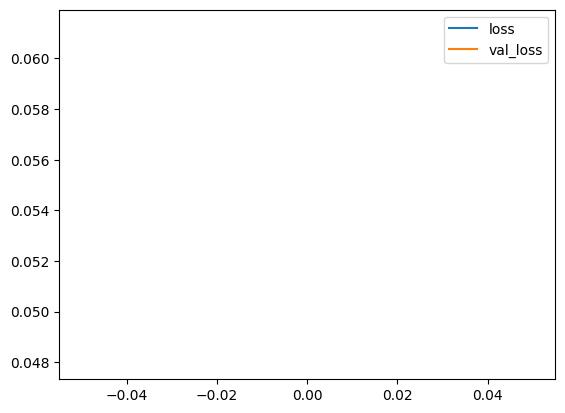

In [30]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [31]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [32]:
model.predict(np.expand_dims(input_text, axis=0))

1/1 [==============================] - 1s 546ms/step


array([[0.99841595, 0.30330577, 0.9466153 , 0.0403155 , 0.91434264,
        0.16335301]], dtype=float32)

In [33]:
res = model.predict(np.expand_dims(input_text, axis=0))

1/1 [==============================] - 0s 77ms/step


In [34]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [35]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [36]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 127ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [37]:
res.shape

(1, 6)

In [38]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [40]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 116ms/step


In [41]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.762565016746521, Recall:0.7401177287101746, Accuracy:0.43630892038345337


In [42]:
!pip install gradio jinja2

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/18.1 MB ? eta -:--:--
    --------------------------------------- 0.3/18.1 MB ? eta -:--:--
    --------------------------------------- 0.3/18.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/18.1 MB 885.6 kB/s eta 0:00:20
   -- ------------------------------------- 1.0/18.1 MB 1.3 MB/s eta 0:00:14
   ---- ----------------------------------- 1.8/18.1 MB 1.8 MB/s eta 0:00:09
   ----- ---------------------------------- 2.4/18.1 MB 2.0 MB/s eta 0:00:08
   ------ --------------------------------- 3.1/18.1 MB 2.2 MB/s eta 0:00:07
   --------- ------------------------------ 4.2/18.1 MB 2.5 MB/s eta 0:00:06
   ------------ --------------------------- 5.5/18.1 MB 3.0 MB/s eta 0

  You can safely remove it manually.
  You can safely remove it manually.


In [43]:
import tensorflow as tf
import gradio as gr

In [44]:
model.save('dl_model_comment_classifier.h5')

In [46]:
model = tf.keras.models.load_model('dl_model_comment_classifier.h5')

In [47]:
input_str = vectorizer('hey i freaken hate you!')

In [48]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 508ms/step


In [49]:
res

array([[0.8136512 , 0.07100806, 0.47407246, 0.05764922, 0.51165783,
        0.13431643]], dtype=float32)

In [50]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [51]:
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder='Comment to score', label="Enter a comment"),
    outputs=gr.Textbox(label="Toxicity Score")
)

In [52]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://12ff331b0ce4d3853a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 57ms/step
